In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  

from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [ ]:
import gspread
from gspread_dataframe import get_as_dataframe
from google.oauth2.service_account import Credentials

# Укажите путь к вашему JSON-файлу с учётными данными
credentials_path = '../python_files/credential_google_sheet.json'
scope = ["https://www.googleapis.com/auth/spreadsheets"]

# Создание аутентификации
credentials = Credentials.from_service_account_file(credentials_path, scopes=scope)
gc = gspread.authorize(credentials)

# Откройте Google Sheet по URL или по его ID
spreadsheet_url = "https://docs.google.com/spreadsheets/d/1iWqOdNvOdy7Km3JINBSo2wAo6yoPxpQapMShCG1VElQ/edit?gid=0#gid=0" 
spreadsheet = gc.open_by_url(spreadsheet_url)

# Откройте конкретный лист по имени
worksheet = spreadsheet.worksheet("Лист1")

# Импортируйте данные из листа в DataFrame
df = get_as_dataframe(worksheet)

In [ ]:
df

In [ ]:
delete = '''DROP TABLE datamarts.mekhtiev_events_cjm_local ON CLUSTER 'viasat_cluster' sync '''
execute(delete,user = 'kmekhtiev')

query = '''CREATE TABLE datamarts.mekhtiev_events_cjm_local ON CLUSTER 'viasat_cluster'
            (
                events String,
                description String,
                type String,
                page String
                )
             ENGINE = ReplicatedMergeTree('/clickhouse/tables/{shard}/mekhtiev_events_cjm_local', '{replica}')
             ORDER BY events
             '''
execute(query,user = 'kmekhtiev')

In [ ]:
delete = '''DROP TABLE datamarts.mekhtiev_events_cjm_distr ON CLUSTER 'viasat_cluster' sync '''
execute(delete,user = 'kmekhtiev')

query = f'''CREATE TABLE datamarts.mekhtiev_events_cjm_distr ON CLUSTER 'viasat_cluster'
            (
                events String,
                description String,
                type String,
                page String
                )
             
             ENGINE = Distributed(viasat_cluster, datamarts, mekhtiev_events_cjm_local, rand())
             '''
execute(query,user = 'kmekhtiev')

In [ ]:
execute(SQL = f" TRUNCATE TABLE datamarts.mekhtiev_events_cjm_local ON CLUSTER 'viasat_cluster' ", user='kmekhtiev')
connection_clickhouse.insert_df('mekhtiev_events_cjm_distr', df)

print("Данные залиты")

# Функции для реализации графика Sankay

In [3]:
def add_features(new_data):
    
    """Функция генерации новых столбцов для исходной таблицы

    Args:
        df (pd.DataFrame): исходная таблица.
    Returns:
        pd.DataFrame: таблица с новыми признаками.
    """
    
    sorted_mobile = new_data.sort_values(by=['session_id', 'date']).copy()
    # добавляем шаги событий
    sorted_mobile['step'] = sorted_mobile.groupby('profile_id').cumcount() + 1
    
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_mobile['source'] = sorted_mobile['event_name']
    # добавляем целевые узлы
    sorted_mobile['target'] = sorted_mobile.groupby('session_id')['source'].shift(-1)
    
    return sorted_mobile.drop(['event_name'], axis=1)

In [75]:
def add_features(new_data,id):
    
    """Функция генерации новых столбцов для исходной таблицы

    Args:
        df (pd.DataFrame): исходная таблица.
    Returns:
        pd.DataFrame: таблица с новыми признаками.
    """
    
    sorted_mobile = new_data.sort_values(by=['session_id', 'date']).copy()
    # добавляем шаги событий
    sorted_mobile['step'] = sorted_mobile.groupby(id).cumcount() + 1
    
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_mobile['source'] = sorted_mobile['event_name']
    # добавляем целевые узлы
    sorted_mobile['target'] = sorted_mobile.groupby('session_id')['source'].shift(-1)
    
    return sorted_mobile.drop(['event_name'], axis=1)

In [5]:
def get_source_index(new_data):
    
    """Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(new_data['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = new_data[new_data['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict

In [7]:
def generate_random_color():
    
    """Случайная генерация цветов rgba

    Args:
        
    Returns:
        str: Строка со сгенерированными параметрами цвета
    """
    
    # сгенерим значение для каждого канала
    r, g, b = np.random.randint(255, size=3)
    return f'rgba({r}, {g}, {b}, 1)'

In [9]:
def colors_for_sources(mode):
    
    """Генерация цветов rgba

    Args:
        mode (str): сгенерировать случайные цвета, если 'random', а если 'custom' - 
                    использовать заранее подготовленные
    Returns:
        dict: словарь с цветами, соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    if mode == 'random':
        # генерим случайные цвета
        for label in df_comp['source'].unique():
            r, g, b = np.random.randint(255, size=3)            
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    elif mode == 'custom':
        # присваиваем ранее подготовленные цвета
        colors = {"custom_colors": ["rgba(42, 157, 143, 1)", "rgba(38, 70, 83, 1)", "rgba(233, 196, 106, 1)", "rgba(244, 162, 97, 1)", "rgba(231, 111, 81, 1)", "rgba(230, 57, 70, 1)", "rgba(168, 218, 220, 1)", "rgba(69, 123, 157, 1)", "rgba(29, 53, 87, 1)", "rgba(107, 112, 92, 1)", "rgba(183, 183, 164, 1)", "rgba(221, 190, 169, 1)", "rgba(142, 202, 230, 1)", "rgba(33, 158, 188, 1)", "rgba(2, 48, 71, 1)", "rgba(255, 183, 3, 1)", "rgba(251, 133, 0, 1)", "rgba(153, 217, 140, 1)", "rgba(118, 200, 147, 1)", "rgba(52, 160, 164, 1)", "rgba(26, 117, 159, 1)", "rgba(247, 37, 133, 1)", "rgba(181, 23, 158, 1)", "rgba(114, 9, 183, 1)", "rgba(86, 11, 173, 1)", "rgba(72, 149, 239, 1)", "rgba(76, 201, 240, 1)", "rgba(242, 132, 130, 1)", "rgba(132, 165, 157, 1)", "rgba(246, 189, 96, 1)", "rgba(187, 62, 3, 1)", "rgba(204, 213, 174, 1)", "rgba(233, 237, 201, 1)", "rgba(254, 250, 224, 1)", "rgba(212, 163, 115, 1)", "rgba(96, 108, 56, 1)", "rgba(40, 54, 24, 1)", "rgba(249, 199, 79, 1)", "rgba(144, 190, 109, 1)", "rgba(67, 170, 139, 1)", "rgba(77, 144, 142, 1)", "rgba(87, 117, 144, 1)", "rgba(39, 125, 161, 1)", "rgba(239, 71, 111, 1)", "rgba(255, 209, 102, 1)", "rgba(6, 214, 160, 1)", "rgba(17, 138, 178, 1)", "rgba(7, 59, 76, 1)", "rgba(0, 53, 102, 1)", "rgba(226, 175, 255, 1)", "rgba(248, 173, 157, 1)", "rgba(211, 211, 211, 1)", "rgba(254, 228, 64, 1)", "rgba(241, 91, 181, 1)", "rgba(155, 93, 229, 1)", "rgba(0, 187, 249, 1)", "rgba(0, 245, 212, 1)", "rgba(130, 192, 204, 1)", "rgba(128, 185, 24, 1)", "rgba(43, 147, 72, 1)"]}
        for no, label in enumerate(df_comp['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]
            
    return colors_dict

In [11]:
def percent_users(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

In [13]:
from plotly import graph_objects as go
import plotly.io as pio  

def lists_for_plot(source_indexes, colors, frac=30):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []
    

    # проходим по каждому шагу
    for step in tqdm(sorted(df_comp['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue
        

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in (temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}

In [15]:
def plot_senkey_diagram(data_dict, file_name="sankey_diagram.html",chart_name='Sankay Diagram'):    
    
    """
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text=chart_name, font_size=10, width=1500, height=800)
    
    # Сохраняем график в HTML файл  
    pio.write_html(fig, file=file_name, auto_open=True)  
    
    # возвращаем объект диаграммы
    return fig.show()

# Загружаем датасет

In [77]:
query = f'''
            SELECT 
            date,
            utc_timestamp,
            visitor_id,
            profile_id,
            session_id,
            event_name,
            client_type
            FROM datamarts.sandbox_data_distr AS t1
            INNER JOIN (SELECT * FROM datamarts.mekhtiev_events_cjm_distr -- WHERE type='flow_chart'
            ) AS t2  ON t1.event_name = t2.events
            WHERE date BETWEEN '2024-09-20'  AND '2024-12-20'  -- Изменение дат!!!!!!!!!!!!!!
            AND profile_id IS NOT NULL AND client_type IN ('web_desktop')
'''

df = execute(query,user='kmekhtiev')

Время выполнения функции: 10.2925 секунд



In [95]:
query = f'''
  SELECT 
            date,
            utc_timestamp,
            visitor_id,
            profile_id,
            session_id,
            event_name,
            JSONExtractString(payload,'from') AS from_payload,
            client_type
            FROM datamarts.clean_event AS t1
            WHERE date BETWEEN '2024-12-20'  AND '2024-12-25'  -- Изменение дат!!!!!!!!!!!!!!
            AND event_name in ('goto_auth_page','click_auth_continue','show_login_password_page','auto_auth_success_authorization')
            AND client_type IN ('web_desktop','web_mobile')
'''

df = execute(query,user='kmekhtiev')

Время выполнения функции: 2.1429 секунд



In [107]:
df_wo_dublicate = df.drop_duplicates(subset=['session_id','event_name'])

df_add = add_features(df_wo_dublicate,id='visitor_id') # 1-ая функция
# plt.figure(figsize=(10,6))
# sns.histplot(df_add['step'])
# plt.xticks(range(int(df_add['step'].min()), int(df_add['step'].max()) + 1,5),rotation=45)  
# plt.yticks(range(0, int(df_add['step'].value_counts().max())+500,500))
# plt.show()

In [109]:
df['event_name'].unique()

array(['click_auth_continue', 'goto_auth_page',
       'show_login_password_page', 'auto_auth_success_authorization'],
      dtype=object)

In [113]:
df_add

,date,utc_timestamp,visitor_id,profile_id,session_id,from_payload,client_type,step,source,target
1854,2024-12-21,2024-12-21 14:30:10,842db7da-8326-4b15-9bc5-bd8da3810b0e,None,0009b5b3-4942-4d78-bdad-0f5427fb14ac,,web_mobile,1,click_auth_continue,NaN
11343,2024-12-23,2024-12-23 01:50:05,43160ea6-4bd7-4e77-8711-2623490b0496,None,001beb98-9125-4979-88ae-c6b5e1152f8a,,web_mobile,1,click_auth_continue,NaN
14331,2024-12-25,2024-12-25 14:34:27,d045540b-8091-40d0-b9c3-378d558023b2,None,00261c81-65a7-470c-b790-223dac8523d4,,web_mobile,1,click_auth_continue,NaN
4562,2024-12-23,2024-12-23 15:43:10,a60749e2-db25-4cb4-9bc2-5d0d43de663e,None,00424e63-e589-42fa-889d-2f9739ed6f21,,web_mobile,1,click_auth_continue,NaN
1554,2024-12-21,2024-12-21 12:35:46,e6c28f42-c675-451d-bd10-7dfffa2a8803,None,0055671e-c203-4b0e-8c21-5cdacf2949f1,sign_in,web_mobile,1,goto_auth_page,NaN
...,...,...,...,...,...,...,...,...,...,...
5484,2024-12-22,2024-12-22 12:12:14,98341d21-eaee-46b6-87bb-d6f30cb66cab,None,ffea37c8-b7a4-43dc-9f1a-2535bfeae733,,web_desktop,4,show_login_password_page,NaN
6301,2024-12-20,2024-12-20 09:23:43,d53abab0-de5d-49b2-be37-5ecd65012fd4,None,fff73c70-5341-4045-9fb3-fa0d5005ec61,,web_desktop,1,click_auth_continue,NaN
9711,2024-12-24,2024-12-24 07:02:38,623527cc-37bb-42fa-a3db-d30be421288f,None,fff90f3c-53e0-4ff7-bfc4-eb29bacccdd4,,web_mobile,1,click_auth_continue,auto_auth_success_authorization
11195,2024-12-24,2024-12-24 07:02:44,623527cc-37bb-42fa-a3db-d30be421288f,4531afb4-3006-4d8e-8161-ca027f2a6085,fff90f3c-53e0-4ff7-bfc4-eb29bacccdd4,,web_mobile,2,auto_auth_success_authorization,show_login_password_page


Шаг: 100%|██████████| 6/6 [00:00<00:00, 67.95it/s]


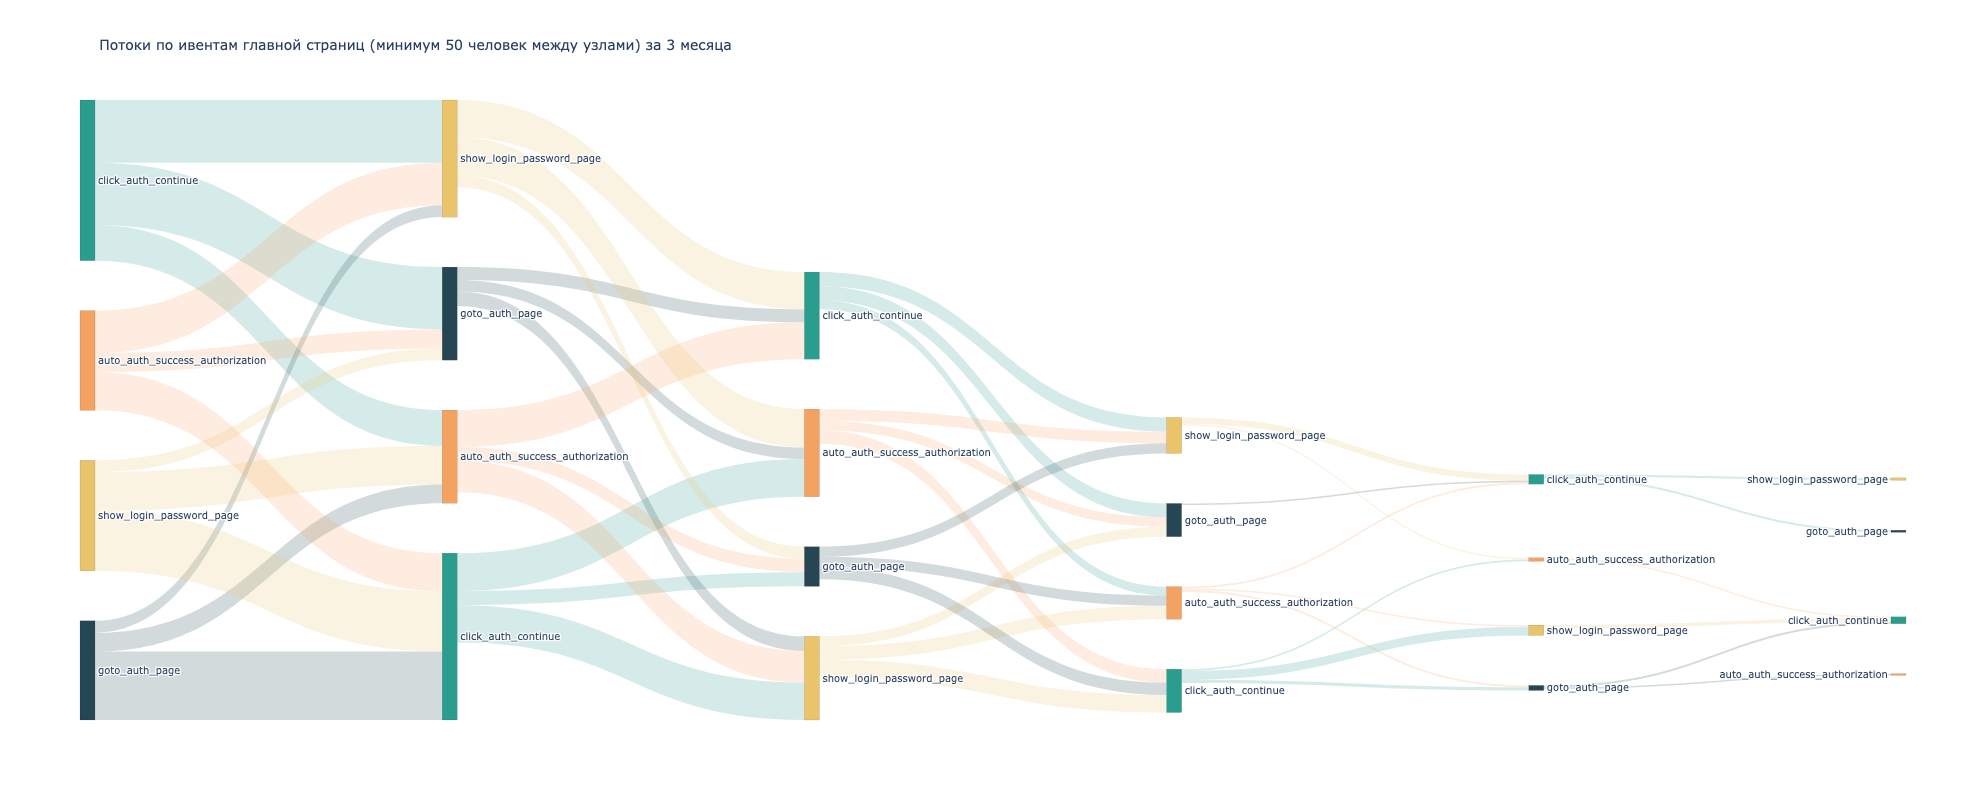

In [111]:
# Ставим ограничение на число шагов в сценарии
df_comp = df_add[(df_add['step']<7].copy().reset_index(drop=True)

# создаем словарь
source_indexes = get_source_index(df_comp) # 2-ая функция

# генерю цвета из своего списка
colors_dict = colors_for_sources(mode='custom') # 3-ая функция

 
data_for_plot = lists_for_plot(source_indexes,colors_dict, frac = 5)  # 4-ая функция. Задаем число пользователей 

# Рисуем график
senkey_diagram = plot_senkey_diagram(data_for_plot,file_name="sankey_diagram_main_events.html", chart_name = 'Потоки по ивентам главной страниц (минимум 50 человек между узлами) за 3 месяца') # финальная 5-ая функция 

In [ ]:
# Ставим ограничение на число шагов в сценарии
df_comp = df_add[df_add['step']<7].copy().reset_index(drop=True)

# создаем словарь
source_indexes = get_source_index(df_comp) # 2-ая функция

# генерю цвета из своего списка
colors_dict = colors_for_sources(mode='custom') # 3-ая функция

 
data_for_plot = lists_for_plot(source_indexes,colors_dict, frac = 50)  # 4-ая функция. Задаем число пользователей 

# Рисуем график
senkey_diagram = plot_senkey_diagram(data_for_plot,file_name="sankey_diagram_all_events.html", chart_name = 'Потоки по всем ивентам (минимум 50 человек между узлами) за 3 месяца') # финальная 5-ая функция 

In [ ]:
df_comp['source'].unique()

In [ ]:
scenario = ['show_subscribe_offer_page','goto_main_page','goto_tv_page']


sorter = pd.DataFrame({'source':scenario,'key':range(len(scenario))})


test = df_comp[(df_comp['source']== sorter.iloc[0,0]) & (df_comp['step']==1)]['profile_id'].unique()
u = df_comp[df_comp['profile_id'].isin(test)]

values=[]
values.append(test.shape[0])
for i in sorter['source'].unique()[1:]:
    test = u[u['source']==i].profile_id.unique()
    u = u[u['profile_id'].isin(test)]
    values.append(test.shape[0])
    
sorter['profile_id'] = values
sorter = sorter[sorter['profile_id']>0]

#Построим воронку по сценарию с учетом перехода от одного действия к следующему
fig2 = go.Figure()
fig2.add_trace(go.Funnel(
y=sorter['source'],
    x=sorter['profile_id'],
    textinfo='value+percent initial'
))
fig2.update_layout(title_text='Воронка по сценарию')
fig2.show()